# Predicción del precio en Airbnb

## Análisis exploratorio y preprocesamiento

### Librerías

In [1]:
## IMPORTS
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# https://ipython.readthedocs.io/en/stable/interactive/plotting.html
%matplotlib inline 

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

### Separación del conjunto de datos en train y test

In [2]:
from sklearn.model_selection import train_test_split

full_df = pd.read_csv("airbnb-listings-extract.csv", sep=";", decimal='.')
train, test = train_test_split(full_df, test_size=0.2, shuffle=True, random_state=0)

print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')

# Guardamos
train.to_csv('./train.csv', sep=';', decimal='.', index=False)
test.to_csv('./test.csv', sep=';', decimal='.', index=False)

Dimensiones del dataset de training: (11824, 89)
Dimensiones del dataset de test: (2956, 89)


### Análisis exploratorio 

In [3]:
# A partir de este momento cargamos el dataset de train y trabajamos ÚNICAMENTE con él. 

airbnb = pd.read_csv('./train.csv', sep=';', decimal='.')

In [4]:
# Nos quedamos solo con los datos de Madrid
airbnb = airbnb[airbnb['City'].str.contains('mad', case=False, regex=False, na=False)]
airbnb['City'].unique()

array(['Madrid', 'Madrid, Comunidad de Madrid, ES', 'las matas  madrid',
       'Delicias-Madrid', 'Madrid, Comunidad de Madrid, ESPANA', 'madrid',
       'Madri', 'MADRID', 'Madid', 'Chueca, Madrid', 'Aravaca (Madrid)'],
      dtype=object)

In [5]:
# Análisis del dataset
N, d = airbnb.shape
print(f'El numero de muestras es {N} y la dimensionalidad del espacio de entrada es {d}.')

El numero de muestras es 10596 y la dimensionalidad del espacio de entrada es 89.


object     53
float64    23
int64      13
dtype: int64


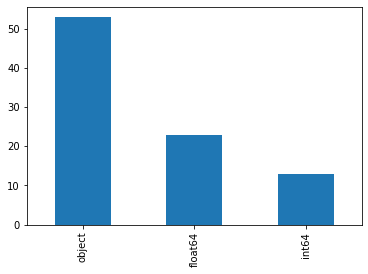

In [6]:
# Conteo de filas de cada tipo de dato en el dataset
pd.value_counts(airbnb.dtypes).plot.bar()
print(airbnb.dtypes.value_counts())

In [7]:
# Guardamos la fecha de los datos en una variable para usarla en cálculo de variables más adelante:
from datetime import datetime
last_day = airbnb['Last Scraped'].unique()[0]
last_day = datetime.strptime(last_day,'%Y-%m-%d').date()

#### Análisis inicial de missing values

In [8]:
# Nos quedamos con las variables que tienen un porcentaje de missing values menor o igual a 25
missing_pctg = airbnb.isnull().sum() * 100 / airbnb.shape[0]
sel_cols = missing_pctg[missing_pctg<=25].index.tolist()

In [9]:
# Comprobamos las columnas a descartar por si alguna se considera relevante
cols_to_discard = missing_pctg[missing_pctg>=25].index.tolist()
airbnb[cols_to_discard].isnull().sum()

Space                     2845
Neighborhood Overview     3960
Notes                     6545
Transit                   4005
Access                    4566
Interaction               4570
House Rules               3733
Host About                3956
Host Acceptance Rate     10596
Neighbourhood             3549
Square Feet              10182
Weekly Price              7891
Monthly Price             7917
Security Deposit          6041
Cleaning Fee              4302
Has Availability         10596
License                  10398
Jurisdiction Names       10596
dtype: int64

In [10]:
# Nos fijamos en las variables numéricas
airbnb[cols_to_discard].describe()

Square Feet  Weekly Price  Monthly Price  Security Deposit  \
count   414.000000   2705.000000    2679.000000       4555.000000   
mean    374.359903    370.728651    1355.135498        183.884523   
std     556.612831    190.609992    1000.628732        110.560392   
min       0.000000     70.000000     250.000000         70.000000   
25%       0.000000    210.000000     700.000000        100.000000   
50%      93.500000    350.000000    1200.000000        150.000000   
75%     646.000000    495.000000    1700.000000        200.000000   
max    5167.000000    999.000000   25000.000000        990.000000   

       Cleaning Fee  
count   6294.000000  
mean      30.000953  
std       27.081129  
min        5.000000  
25%       15.000000  
50%       25.000000  
75%       35.000000  
max      500.000000

In [11]:
# Mantenemos "Security Deposit" y "Cleaning Fee" por ser variables monetarias
sel_cols += ['Security Deposit', 'Cleaning Fee']
airbnb = airbnb[sel_cols]

In [12]:
cols_to_discard.remove('Cleaning Fee')
cols_to_discard.remove('Security Deposit')

In [13]:
cols_to_discard

['Space',
 'Neighborhood Overview',
 'Notes',
 'Transit',
 'Access',
 'Interaction',
 'House Rules',
 'Host About',
 'Host Acceptance Rate',
 'Neighbourhood',
 'Square Feet',
 'Weekly Price',
 'Monthly Price',
 'Has Availability',
 'License',
 'Jurisdiction Names']

In [14]:
#airbnb['Space'].value_counts() #--> "Texto"
#airbnb['Neighborhood Overview'].value_counts() #--> "Texto"
#airbnb['Notes'].value_counts() #--> "Texto"
#airbnb['Transit'].value_counts()  #--> "Texto"
#airbnb['Access'].value_counts() #--> "Texto"
#airbnb['Interaction'].value_counts() #--> "Texto"
#airbnb['House Rules'].value_counts() #--> "Texto"

Las variables:

  "Has Availability", "License", "Jurisdiction Names", "Host Acceptance Rate", "Square Feet"
  
tienen un número muy alto de missing values   

 - Categóricas:

  "Space", "Neighborhood Overview", "Notes", "Transit", "Access", "Interaction", "House Rules"
  
son variables que contienen texto (se podría profundizar y extraer más información de ellas)


 - Numéricas:

 "Monthly Price" y "Weekly Price" 
 
se descartan por tener muchos nulos

#### Análisis de las variables object

In [15]:
# Análisis de las variables tipo object:
obj_cols = airbnb.count()[airbnb.dtypes == object].index.tolist()
airbnb_obj = airbnb[obj_cols]
airbnb_obj.head(2)

Listing Url Last Scraped  \
0   https://www.airbnb.com/rooms/5994463   2017-04-08   
1  https://www.airbnb.com/rooms/14136180   2017-04-08   

                               Name  \
0  PISO ATOCHA- FLAT NEAR ATOCHA  .   
1            The Palace Sol Madrid.   

                                             Summary  \
0  Piso recién reformado cómoda habitación con ba...   
1  Lugares de interés: Plaza Mayor, Plaza del Sol...   

                                         Description Experiences Offered  \
0  Piso recién reformado cómoda habitación con ba...                none   
1  Lugares de interés: Plaza Mayor, Plaza del Sol...                none   

                                       Thumbnail Url  \
0  https://a0.muscache.com/im/pictures/74652419/f...   
1  https://a0.muscache.com/im/pictures/1565a3a9-2...   

                                          Medium Url  \
0  https://a0.muscache.com/im/pictures/74652419/f...   
1  https://a0.muscache.com/im/pictures/1565a3a9-2...   

                                         Picture Url  \
0  https://public.opendatasoft.com/api/v2/catalog...   
1  https://public.opendatasoft.com/api/v2/catalog...   

                                      XL Picture Url  ...        Room Type  \
0  https://a0.muscache.com/im/pictures/74652419/f...  ...  Entire home/apt   
1  https://a0.muscache.com/im/pictures/1565a3a9-2...  ...  Entire home/apt   

   Bed Type                                          Amenities  \
0  Real Bed  TV,Internet,Wireless Internet,Air conditioning...   
1  Real Bed  TV,Internet,Wireless Internet,Air conditioning...   

  Calendar Updated Calendar last Scraped First Review Last Review  \
0      2 weeks ago            2017-04-08   2015-04-26  2017-02-28   
1            today            2017-04-08   2016-08-05  2017-03-20   

  Cancellation Policy                   Geolocation  \
0            moderate  40.4077318793,-3.68481869733   
1            flexible  40.4158022422,-3.70534037765   

                                            Features  
0  Host Has Profile Pic,Is Location Exact,Require...  
1  Host Has Profile Pic,Host Identity Verified,Re...  

[2 rows x 40 columns]

In [16]:
# Valores distintos en cada columna
#airbnb.nunique()[airbnb.dtypes == object]
airbnb_obj.nunique()

Listing Url                     10596
Last Scraped                        1
Name                            10321
Summary                          9641
Description                     10284
Experiences Offered                 1
Thumbnail Url                    8577
Medium Url                       8577
Picture Url                     10575
XL Picture Url                   8577
Host URL                         6783
Host Name                        2624
Host Since                       1985
Host Location                     439
Host Response Time                  4
Host Thumbnail Url               6751
Host Picture Url                 6751
Host Neighbourhood                104
Host Verifications                177
Street                            643
Neighbourhood Cleansed            126
Neighbourhood Group Cleansed       21
City                               11
State                              16
Zipcode                            70
Market                              4
Smart Locati

In [17]:
# Variables categóricas a eliminar por considerarse que no tienen relevancia en el precio
cols_obj_to_drop = []
cols_obj_to_drop += ['Listing Url', 'Last Scraped', 'Name', 'Summary', 'Description',
                     'Thumbnail Url', 'Medium Url', 'Picture Url',
       'XL Picture Url', 'Host URL', 'Host Name', 'Host Neighbourhood', 
                     'Host Thumbnail Url','Host Picture Url', 'Host Verifications', 
                     'Calendar Updated','Features'] 
# Variables categóricas a eliminar por considerarse redundantes en la información aportada                      
cols_obj_to_drop += ['Street',
       'Neighbourhood Cleansed',
       'City',
       'State', 'Zipcode', 'Market', 'Smart Location', 'Country Code',
       'Country', 
       'Geolocation']
# Variables categóricas con solo 1 o 2 valores y  sin relevancia
cols_obj_to_drop += ['Experiences Offered','Calendar last Scraped']
# Variables categóricas que podrían no estar completamente representadas en el conjunto de train
#cols_obj_to_drop += ['Neighbourhood Cleansed'] #,'Neighbourhood Group Cleansed']

En la siguiente celda comentada se indica el tratamiento que se hará de las variables categóricas seleccionadas:

In [18]:
# Análisis preliminar de variables a codificar

#airbnb['Host Response Time'].value_counts() ---> CODIFICAR
#airbnb['Neighbourhood Cleansed'].value_counts() ---> CODIFICAR
#airbnb['Host Since'].value_counts() ---> new_var: antigüedad del host
#airbnb['Host Location'].value_counts() ---> new_var: host local o no local
#airbnb['Property Type'].value_counts() ---> codificar
#airbnb['Room Type'].value_counts() ---> CODIFICAR
#airbnb['Bed Type'].value_counts() ---CODIFICAR
#airbnb['Amenities'].value_counts() ---> new_var: wifi s/n, air conditioning s/n, etc 
#airbnb['Cancellation Policy'].value_counts() ---> codificar
#airbnb['Features'].value_counts() ---> se podrían sacar más variables
#airbnb['First Review'].value_counts() ---> new var: días entre la primera y la ultima review


In [19]:
airbnb_obj = airbnb_obj.drop(cols_obj_to_drop, axis=1)

In [20]:
# Valores distintos de cada variable categórica
airbnb_obj.nunique()[airbnb.dtypes == object]

Host Since                      1985
Host Location                    439
Host Response Time                 4
Neighbourhood Group Cleansed      21
Property Type                     20
Room Type                          3
Bed Type                           5
Amenities                       9050
First Review                    1510
Last Review                      657
Cancellation Policy                5
dtype: int64

#### Análisis de las variables numéricas (enteros)

In [21]:
airbnb.count()[airbnb.dtypes == int]

ID                   10596
Scrape ID            10596
Host ID              10596
Accommodates         10596
Guests Included      10596
Extra People         10596
Minimum Nights       10596
Maximum Nights       10596
Availability 30      10596
Availability 60      10596
Availability 90      10596
Availability 365     10596
Number of Reviews    10596
dtype: int64

In [22]:
cols_int = airbnb.count()[airbnb.dtypes == int].index.tolist()
airbnb[cols_int].describe()

ID     Scrape ID       Host ID  Accommodates  \
count  1.059600e+04  1.059600e+04  1.059600e+04  10596.000000   
mean   1.036689e+07  2.017041e+13  3.708702e+07      3.187240   
std    5.514917e+06  4.343955e+00  3.418412e+07      1.989223   
min    1.986400e+04  2.017041e+13  1.745300e+04      1.000000   
25%    5.778384e+06  2.017041e+13  7.734994e+06      2.000000   
50%    1.144733e+07  2.017041e+13  2.709743e+07      2.000000   
75%    1.533305e+07  2.017041e+13  5.620819e+07      4.000000   
max    1.810984e+07  2.017041e+13  1.247534e+08     16.000000   

       Guests Included  Extra People  Minimum Nights  Maximum Nights  \
count     10596.000000  10596.000000    10596.000000    10596.000000   
mean          1.568894      7.421952        3.088618      976.703851   
std           1.071520     10.611499       14.112525     9915.143949   
min           1.000000      0.000000        1.000000        1.000000   
25%           1.000000      0.000000        1.000000      365.000000   
50%           1.000000      0.000000        2.000000     1125.000000   
75%           2.000000     14.000000        3.000000     1125.000000   
max          16.000000    276.000000     1125.000000  1000000.000000   

       Availability 30  Availability 60  Availability 90  Availability 365  \
count     10596.000000     10596.000000     10596.000000      10596.000000   
mean          8.717441        22.850698        39.987071        205.710079   
std           9.074897        19.512065        29.343622        127.075163   
min           0.000000         0.000000         0.000000          0.000000   
25%           0.000000         5.000000        12.000000         83.000000   
50%           6.000000        20.000000        38.000000        248.000000   
75%          13.000000        38.000000        65.000000        320.000000   
max          30.000000        60.000000        90.000000        365.000000   

       Number of Reviews  
count       10596.000000  
mean           23.152605  
std            38.343747  
min             0.000000  
25%             1.000000  
50%             7.000000  
75%            28.000000  
max           356.000000

In [23]:
# Podemos dropear las variables de ID:
cols_int_to_drop = []
cols_int_to_drop += ['ID', 'Scrape ID', 'Host ID']

#### Análisis de las variables numéricas (float)

In [24]:
airbnb.count()[airbnb.dtypes == float]

Host Response Rate                 9280
Host Listings Count               10593
Host Total Listings Count         10593
Latitude                          10596
Longitude                         10596
Bathrooms                         10556
Bedrooms                          10578
Beds                              10559
Price                             10588
Review Scores Rating               8305
Review Scores Accuracy             8289
Review Scores Cleanliness          8294
Review Scores Checkin              8283
Review Scores Communication        8293
Review Scores Location             8280
Review Scores Value                8281
Calculated host listings count    10596
Reviews per Month                  8412
Security Deposit                   4555
Cleaning Fee                       6294
dtype: int64

In [25]:
cols_float = airbnb.count()[airbnb.dtypes == float].index.tolist()
airbnb[cols_float].describe()

Host Response Rate  Host Listings Count  Host Total Listings Count  \
count         9280.000000         10593.000000               10593.000000   
mean            94.826509             9.971113                   9.971113   
std             15.264873            27.932863                  27.932863   
min              0.000000             0.000000                   0.000000   
25%            100.000000             1.000000                   1.000000   
50%            100.000000             2.000000                   2.000000   
75%            100.000000             5.000000                   5.000000   
max            100.000000           265.000000                 265.000000   

           Latitude     Longitude     Bathrooms      Bedrooms          Beds  \
count  10596.000000  10596.000000  10556.000000  10578.000000  10559.000000   
mean      40.420429     -3.697127      1.256963      1.295235      1.992424   
std        0.019877      0.023387      0.607956      0.832757      1.529200   
min       40.332908     -3.863907      0.000000      0.000000      1.000000   
25%       40.410074     -3.707768      1.000000      1.000000      1.000000   
50%       40.418457     -3.701561      1.000000      1.000000      1.000000   
75%       40.427683     -3.693864      1.000000      2.000000      2.000000   
max       40.562736     -3.575142      8.000000     10.000000     16.000000   

              Price  Review Scores Rating  Review Scores Accuracy  \
count  10588.000000           8305.000000             8289.000000   
mean      66.127692             91.585792                9.405598   
std       56.113258              9.104980                0.936985   
min        9.000000             20.000000                2.000000   
25%       31.000000             88.000000                9.000000   
50%       52.000000             94.000000               10.000000   
75%       80.000000             98.000000               10.000000   
max      875.000000            100.000000               10.000000   

       Review Scores Cleanliness  Review Scores Checkin  \
count                8294.000000            8283.000000   
mean                    9.321196               9.626464   
std                     1.007409               0.789808   
min                     2.000000               2.000000   
25%                     9.000000               9.000000   
50%                    10.000000              10.000000   
75%                    10.000000              10.000000   
max                    10.000000              10.000000   

       Review Scores Communication  Review Scores Location  \
count                  8293.000000             8280.000000   
mean                      9.648016                9.546256   
std                       0.752834                0.759231   
min                       2.000000                2.000000   
25%                       9.000000                9.000000   
50%                      10.000000               10.000000   
75%                      10.000000               10.000000   
max                      10.000000               10.000000   

       Review Scores Value  Calculated host listings count  Reviews per Month  \
count          8281.000000                    10596.000000        8412.000000   
mean              9.208429                        7.749717           1.927027   
std               0.964731                       19.881381           1.890040   
min               2.000000                        1.000000           0.020000   
25%               9.000000                        1.000000           0.480000   
50%               9.000000                        2.000000           1.270000   
75%              10.000000                        4.000000           2.880000   
max              10.000000                      145.000000          17.210000   

       Security Deposit  Cleaning Fee  
count       4555.000000   6294.000000  
mean         183.884523     30.000953  
std          110.560392     27.081129 

Eliminamos las siguientes variables (celda siguiente comentada):

In [26]:

# Host Response Rate (la mayoría de valores son 100)
# Host Total Listings Count (contiene los mismos valores que Host Listings Count)
# Weekly Price
# Monthly Price
# Calculated host listings count  (parece una variable calculada a partir de Host Listings Count)


In [27]:
# Podemos dropear:
cols_float_to_drop = []
#airbnb = airbnb.drop(['Host Response Rate', 'Host Total Listings Count', 'Latitude', 'Longitude',
                     #'Weekly Price', 'Monthly Price','Calculated host listings count'], axis=1)
cols_float_to_drop += ['Host Response Rate', 'Host Total Listings Count', #'Latitude', 'Longitude',
                     'Calculated host listings count']

In [28]:
cols_to_drop = cols_obj_to_drop + cols_int_to_drop + cols_float_to_drop
airbnb = airbnb.drop(cols_to_drop, axis=1)

In [29]:
airbnb.isnull().sum().sort_values(ascending = False)

Security Deposit                6041
Cleaning Fee                    4302
Review Scores Location          2316
Review Scores Value             2315
Review Scores Checkin           2313
Review Scores Accuracy          2307
Review Scores Communication     2303
Review Scores Cleanliness       2302
Review Scores Rating            2291
Last Review                     2185
First Review                    2184
Reviews per Month               2184
Host Response Time              1316
Amenities                         91
Bathrooms                         40
Beds                              37
Host Location                     33
Bedrooms                          18
Price                              8
Host Listings Count                3
Host Since                         3
Guests Included                    0
Property Type                      0
Cancellation Policy                0
Number of Reviews                  0
Availability 365                   0
Neighbourhood Group Cleansed       0
L

#### Análisis de la correlación

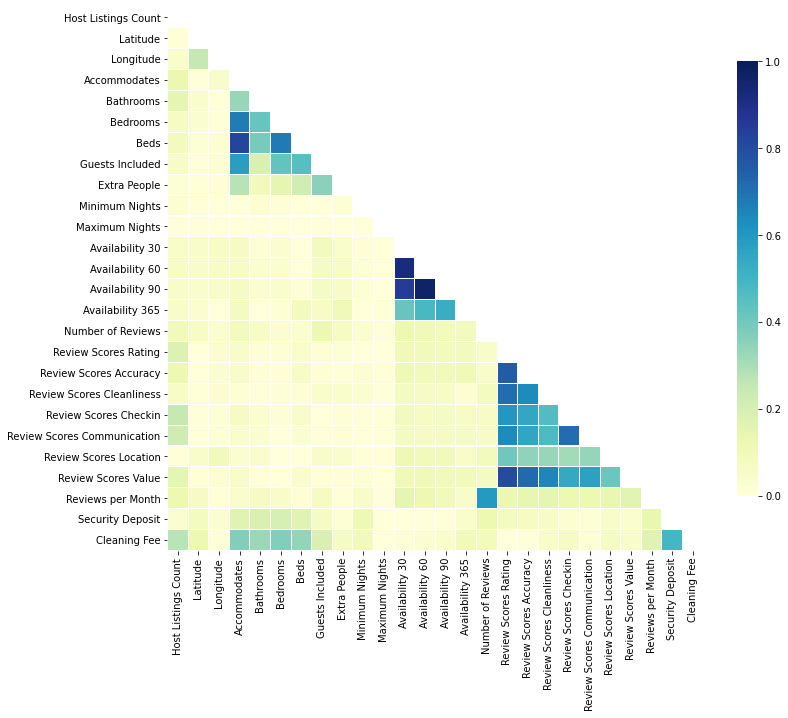

In [30]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(airbnb.drop(['Price'], axis=1).corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

Variables numéricas con alta correlación: Accomodates - Beds, Availability 30 - Availability 60 - Availability 90 - Availability 365, Review Score Value - Review Score Rating, Reviews per Month - Number of Reviews

In [31]:
# Eliminamos variables numéricas con alta correlación
cols_cor_to_drop = ['Beds', 'Bedrooms','Availability 30','Availability 60', 'Availability 90', 
                    'Review Scores Value',
                    #'Review Scores Location',
                    #'Review Scores Checkin',
                    'Review Scores Accuracy', 
                    'Review Scores Communication',
                    #'Review Scores Cleanliness',
                    'Reviews per Month']
airbnb = airbnb.drop(cols_cor_to_drop, axis=1)


In [32]:
airbnb.shape

(10596, 29)

### Codificación de variables

In [33]:
airbnb.nunique()[airbnb.dtypes == object]

Host Since                      1985
Host Location                    439
Host Response Time                 4
Neighbourhood Group Cleansed      21
Property Type                     20
Room Type                          3
Bed Type                           5
Amenities                       9050
First Review                    1510
Last Review                      657
Cancellation Policy                5
dtype: int64

In [34]:
# Utilizamos get_dummies para la variable de barrios agrupados
airbnb = pd.get_dummies(airbnb, prefix = ['Neigh'], columns = ['Neighbourhood Group Cleansed'])

#airbnb = pd.get_dummies(airbnb, prefix = ['Resp'], columns = ['Host Response Time'])
#airbnb = pd.get_dummies(airbnb, prefix = ['Prop'], columns = ['Property Type'])
#airbnb = pd.get_dummies(airbnb, prefix = ['Room'], columns = ['Room Type'])
#airbnb = pd.get_dummies(airbnb, prefix = ['Bed'], columns = ['Bed Type'])
#airbnb = pd.get_dummies(airbnb, prefix = ['Cancel'], columns = ['Cancellation Policy'])

In [35]:
categorical = ['Host Response Time', 'Property Type', 'Room Type', 'Bed Type', 'Cancellation Policy']

mean_map = {}
for c in categorical:
    mean = airbnb.groupby(c)['Price'].mean()
    airbnb[c] = airbnb[c].map(mean)    
    mean_map[c] = mean

### Missing values

In [36]:
# Eliminamos los registros del dataset que no tienen valor de precio
airbnb = airbnb.dropna(subset=['Price'])

In [37]:
airbnb.isnull().sum().sort_values(ascending = False)

Security Deposit               6035
Cleaning Fee                   4298
Review Scores Location         2311
Review Scores Checkin          2308
Review Scores Cleanliness      2297
Review Scores Rating           2286
Last Review                    2180
First Review                   2179
Host Response Time             1314
Amenities                        89
Bathrooms                        39
Host Location                    33
Host Listings Count               3
Host Since                        3
Neigh_Ciudad Lineal               0
Accommodates                      0
Extra People                      0
Guests Included                   0
Price                             0
Neigh_Salamanca                   0
Bed Type                          0
Neigh_San Blas - Canillejas       0
Room Type                         0
Maximum Nights                    0
Property Type                     0
Longitude                         0
Latitude                          0
Neigh_Tetuán                

In [38]:
# Rellenamos los valores faltantes con diversos criterios
lista2fillna = airbnb.isnull().sum()

cols2fillna = lista2fillna[lista2fillna.values >0].index

for col in cols2fillna:
    if(col == 'Security Deposit' or col == 'Cleaning Fee'):
        airbnb[col] = airbnb[col].fillna(value=0)
    elif(col == 'Last Review'):
        airbnb[col] = airbnb[col].fillna(value = airbnb['First Review'])
    elif(col == 'First Review'):
        airbnb[col] = airbnb[col].fillna(value = airbnb['Host Since'])
        
    else:
        airbnb[col] = airbnb[col].fillna(airbnb[col].mode()[0])


In [39]:
#airbnb["Review Scores Location"] = airbnb["Review Scores Location"].fillna(airbnb["Review Scores Location"].mode()[0])
#airbnb["Review Scores Checkin"] = airbnb["Review Scores Checkin"].fillna(airbnb["Review Scores Checkin"].mode()[0])
#airbnb["Review Scores Accuracy"] = airbnb["Review Scores Accuracy"].fillna(airbnb["Review Scores Accuracy"].mode()[0])
#airbnb["Review Scores Communication"] = airbnb["Review Scores Communication"].fillna(airbnb["Review Scores Communication"].mode()[0])
#airbnb["Review Scores Cleanliness"] = airbnb["Review Scores Cleanliness"].fillna(airbnb["Review Scores Cleanliness"].mode()[0])
#airbnb["Review Scores Rating"] = airbnb["Review Scores Rating"].fillna(airbnb["Review Scores Rating"].mode()[0])
#airbnb["Bathrooms"] = airbnb["Bathrooms"].fillna(airbnb["Bathrooms"].mode()[0])
#airbnb["Bedrooms"] = airbnb["Bedrooms"].fillna(airbnb["Bedrooms"].mode()[0])
#airbnb["Host Listings Count"] = airbnb["Host Listings Count"].fillna(airbnb["Host Listings Count"].mode()[0])
#airbnb["Host Response Time"] = airbnb["Host Response Time"].fillna(airbnb["Host Response Time"].mode()[0])
#airbnb["Amenities"] = airbnb["Amenities"].fillna(airbnb["Amenities"].mode()[0])
#airbnb["Host Location"] = airbnb["Host Location"].fillna(airbnb["Host Location"].mode()[0])
#airbnb["Host Since"] = airbnb["Host Since"].fillna(airbnb["Host Since"].mode()[0])


In [40]:
#Comprobamos missing values
airbnb.isnull().sum().sort_values(ascending = False)

Neigh_Villaverde               0
Review Scores Checkin          0
Review Scores Rating           0
Last Review                    0
First Review                   0
Number of Reviews              0
Availability 365               0
Maximum Nights                 0
Minimum Nights                 0
Extra People                   0
Guests Included                0
Price                          0
Amenities                      0
Bed Type                       0
Bathrooms                      0
Accommodates                   0
Room Type                      0
Property Type                  0
Longitude                      0
Latitude                       0
Host Listings Count            0
Host Response Time             0
Host Location                  0
Review Scores Cleanliness      0
Review Scores Location         0
Neigh_Villa de Vallecas        0
Cancellation Policy            0
Neigh_Vicálvaro                0
Neigh_Usera                    0
Neigh_Tetuán                   0
Neigh_San 

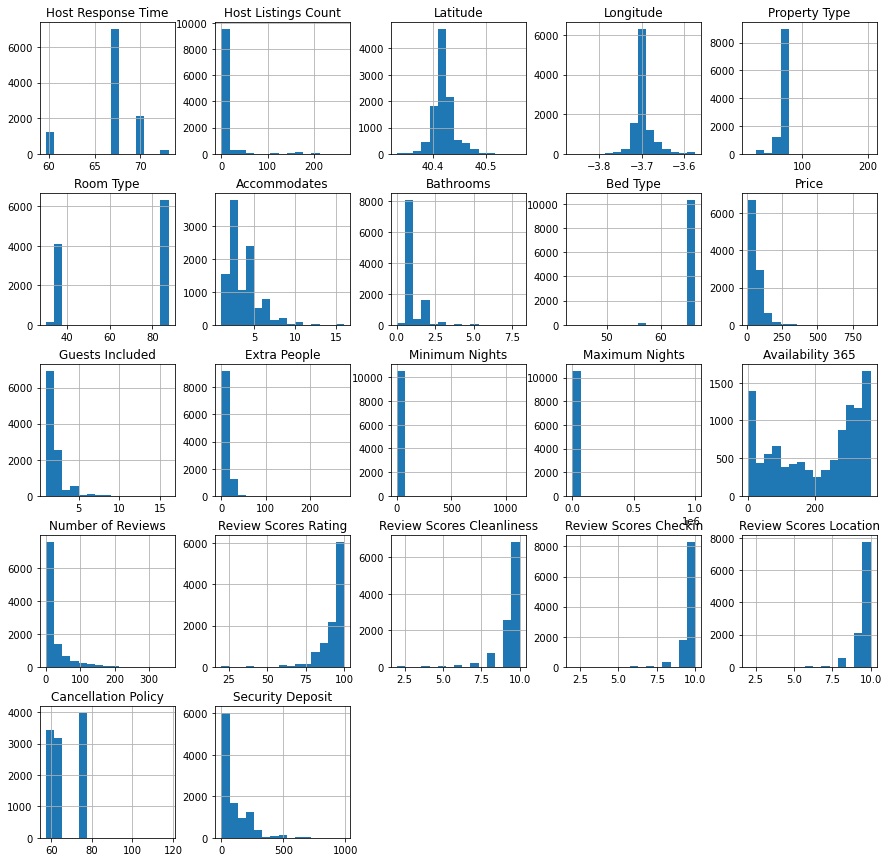

In [41]:
# Histogramas de las variabes numéricas (sin considerar las dummies)
#airbnb[airbnb.describe().columns[0:22]]
airbnb[airbnb.describe().columns[0:22]].hist(bins=15, figsize=(15, 15), layout=(5, 5));

No se observan variables que sigan una distribución próxima a la normal. 

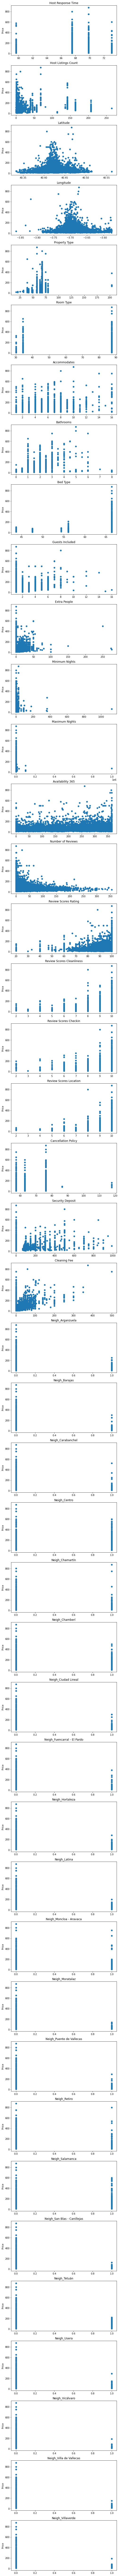

In [42]:
# Relación de las variables independientes con la variable respuesta
airbnb_num = airbnb[airbnb.describe().columns]

columns = list(airbnb_num.columns)
columns.remove('Price')

fig, ax = plt.subplots(len(columns), 1, figsize = (8, 200))

for idx, col in enumerate(columns, 0):
    ax[idx].plot(airbnb_num[col], airbnb_num['Price'], 'o')
    ax[idx].set_ylabel('Price')
    ax[idx].set_title(col)

plt.show()

In [43]:
#airbnb['Extra People'].value_counts().sort_index()
#airbnb['Minimum Nights'].value_counts().sort_index()
airbnb['Maximum Nights'].value_counts().sort_values(ascending=False)[:50]

# Eliminamos la variables "Maximum Nights" porque la distribución de datos es muy variables 
# y gran parte de los registros tienen valor 1125 como máximo de noches.

1125    7443
30       465
365      349
7        206
15       197
60       172
10       152
90       151
5         91
31        87
180       78
3         77
28        73
20        72
14        70
4         65
6         55
120       44
1000      37
29        35
360       35
330       33
8         32
2         30
100       28
300       26
730       26
45        25
40        24
21        23
25        22
200       18
999       17
9         17
12        15
16        13
32        11
150       11
50        11
1         10
35        10
27         9
1825       9
2000       8
11         7
350        6
62         5
70         5
500        5
800        5
Name: Maximum Nights, dtype: int64

Text(0.5, 0, 'Maximum Nights')

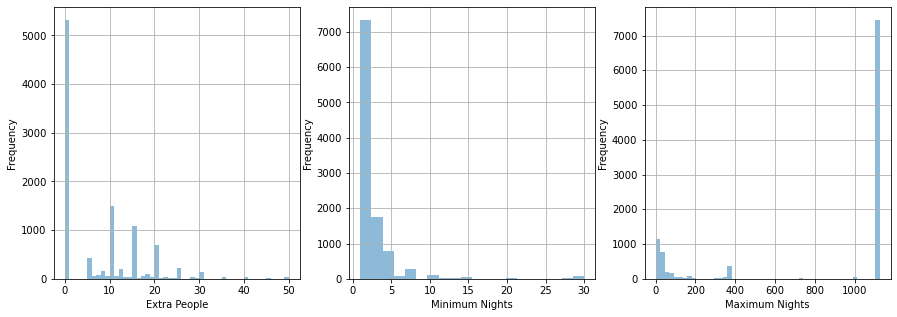

In [44]:
# Analizamos la distribución de valores de las 3 variables que parecen tener outliers:
plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)
filter_extrapeople = airbnb['Extra People'] <= 50
airbnb[filter_extrapeople]['Extra People'].plot.hist(alpha=0.5, bins=50, grid = True)
#plt.axis([0, 300, 0, 10000])
plt.xlabel('Extra People')

plt.subplot(1,3,2)
filter_min_nights = airbnb['Minimum Nights'] <= 31
airbnb[filter_min_nights]['Minimum Nights'].plot.hist(alpha=0.5, bins=20, grid = True)
#plt.axis([0, 300, 0, 10000])
plt.xlabel('Minimum Nights')

plt.subplot(1,3,3)
filter_max_nights = airbnb['Maximum Nights'] <= 1125
airbnb[filter_max_nights]['Maximum Nights'].plot.hist(alpha=0.5, bins=50, grid = True)
#plt.axis([0, 300, 0, 10000])
plt.xlabel('Maximum Nights')


In [45]:
# Eliminamos outliers
#filter_extrapeople = airbnb['Extra People'] <= 200
airbnb = airbnb[filter_extrapeople]
#filter_min_nights = airbnb['Minimum Nights'] <= 365
airbnb = airbnb[filter_min_nights]
#filter_max_nights = airbnb['Maximum Nights'] <= 1125
#airbnb = airbnb[filter_max_nights]

In [46]:
cols_out_to_drop = ['Maximum Nights']
airbnb = airbnb.drop(['Maximum Nights'], axis=1)

In [47]:
airbnb.shape

(10540, 48)

### Generación de variables

In [48]:
from datetime import datetime
#Transformamos variables de fecha
airbnb['Host Since'] = airbnb['Host Since'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d').date())
airbnb['First Review'] = airbnb['First Review'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d').date())
airbnb['Last Review'] = airbnb['Last Review'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d').date())

#datetime.strptime(airbnb['Host Since'].value_counts().index[0], '%Y-%m-%d').date()

In [49]:
### GENERACIÓN DE NUEVAS VARIABLES
# Nueva variable: Antigüedad del propietario en airbnb
import datetime
#today = datetime.date.today()
airbnb['Days As Host'] = airbnb['Host Since'].apply(lambda x: (last_day - x).days)

# Nueva variable: Días transcurridos entre la primera y la última review
#airbnb['Days bt reviews'] = (airbnb['Last Review'] - airbnb['First Review'])
#airbnb['Days bt reviews'] = airbnb['Days bt reviews'].apply(lambda x: int(x.days))
airbnb['Days Since Last Review'] = airbnb['Last Review'].apply(lambda x: (last_day - x).days)

# Nueva variable: booleano que discrimine si el propietario es local o no
airbnb['Host Is Local'] = airbnb['Host Location'].apply(lambda x: 1 if 'mad' in str(x).lower() else 0)

# Dos nuevas variables a partir de la variable "Amenities"
airbnb['Has WIFI'] = airbnb['Amenities'].apply(lambda x: 1 if 'wireless internet' in str(x).lower() else 0)
airbnb['Has AC'] = airbnb['Amenities'].apply(lambda x: 1 if 'air conditioning' in str(x).lower() else 0)
airbnb['Has Ascensor'] = airbnb['Amenities'].apply(lambda x: 1 if 'elevator in building' in str(x).lower() else 0)

In [50]:
cols_gen_to_drop = ['Host Since', 'Host Location', 'Amenities','Last Review', 'First Review']
airbnb = airbnb.drop(['Host Since', 'Host Location', 'Amenities','Last Review', 'First Review'], axis=1)

In [51]:
#airbnb['Host Response Time'].value_counts() ---> CODIFICAR
#airbnb['Neighbourhood Cleansed'].value_counts() ---> CODIFICAR
#airbnb['Host Since'].value_counts() ---> new_var: antigüedad del host
#airbnb['Host Location'].value_counts() ---> new_var: host local o no local
#airbnb['Property Type'].value_counts() ---> codificar
#airbnb['Room Type'].value_counts() ---> CODIFICAR
#airbnb['Bed Type'].value_counts() ---CODIFICAR
#airbnb['Amenities'].value_counts() ---> new_var wifi s/n, air conditioning s/n, etc
#airbnb['Calendar Updated'].value_counts() --> new_var días desde que actualizó el calendario
#airbnb['Cancellation Policy'].value_counts() ---> codificar

In [52]:
airbnb.shape

(10540, 49)

In [53]:
# Guardamos dataframe de train limpio
airbnb.to_csv('./train_clean.csv', sep=';', decimal='.', index=False)

### Preprocesamiento del conjunto de test

In [54]:
test = pd.read_csv('./test.csv', sep=';', decimal='.')

## Preprocesamiento sobre el conjunto de test:
# Eliminamos registros que no son de Madrid
test = test[test['City'].str.contains('mad', case=False, regex=False, na=False)] 

# Eliminamos columnas descartadas
test = test.drop((cols_to_discard + cols_to_drop + cols_cor_to_drop), axis=1)

#---------------------------


# Codificación de variables

test = pd.get_dummies(test, prefix = ['Neigh'], columns = ['Neighbourhood Group Cleansed'])

categorical = ['Host Response Time', 'Property Type', 'Room Type', 'Bed Type', 'Cancellation Policy']

for c in categorical:
    test[c] = test[c].map(mean_map[c])
    
    
#---------------------------

# Missing Values

test = test.dropna(subset=['Price'])

# Rellenamos los valores faltantes con diversos criterios
lista2fillna = test.isnull().sum()


cols2fillna = lista2fillna[lista2fillna.values >0].index


for col in cols2fillna:
    if(col == 'Security Deposit' or col == 'Cleaning Fee'):
        test[col] = test[col].fillna(value=0)
    elif(col == 'Last Review'):
        test[col] = test[col].fillna(value = test['First Review'])
    elif(col == 'First Review'):
        test[col] = test[col].fillna(value = test['Host Since'])
        
    else:
        test[col] = test[col].fillna(test[col].mode()[0])

#---------------------------

#
test = test.drop(cols_out_to_drop, axis=1)

# Generación de nuevas variables

#Transformamos variables de fecha
from datetime import datetime
test['Host Since'] = test['Host Since'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d').date())
test['First Review'] = test['First Review'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d').date())
test['Last Review'] = test['Last Review'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d').date())

# Nueva variable: Antigüedad del propietario en airbnb
test['Days As Host'] = test['Host Since'].apply(lambda x: (last_day - x).days)

# Nueva variable: Días transcurridos entre la primera y la última review
#test['Days bt reviews'] = (test['Last Review'] - test['First Review'])
#test['Days bt reviews'] = test['Days bt reviews'].apply(lambda x: int(x.days))
test['Days Since Last Review'] = test['Last Review'].apply(lambda x: (last_day - x).days)

# Nueva variable: booleano que discrimine si el propietario es local o no
test['Host Is Local'] = test['Host Location'].apply(lambda x: 1 if 'mad' in str(x).lower() else 0)

# Dos nuevas variables a partir de la variable "Amenities"
test['Has WIFI'] = test['Amenities'].apply(lambda x: 1 if 'wireless internet' in str(x).lower() else 0)
test['Has AC'] = test['Amenities'].apply(lambda x: 1 if 'air conditioning' in str(x).lower() else 0)
test['Has Ascensor'] = test['Amenities'].apply(lambda x: 1 if 'elevator in building' in str(x).lower() else 0)

# Eliminamos variables
test = test.drop(cols_gen_to_drop, axis=1)

#---------------------------


# Guardamos
test.to_csv('./test_clean.csv', sep=';', decimal='.', index=False)